# Starbucks Capstone Challenge (ETL part)

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Problem statement
To create a better working and reading experience, I will divide the project into two notebooks "ETL" and "ML".  
The two questions I am going to answer in the project are:  
(1) Which offer type is most popular in term of how successful the offers were viewed and completed?   
(2) Based on demographic features such as "age", "income", "membership_days", and "gender", can we predict whether a customer will view/complete all the offers we send to them?  
In this "ETL" notebook, I will first explore, process and visualize the data provided by Starbucks, and also answer the first question. In the "ML" notebook, I will train a machine learning model to answer the second question. 

In [280]:
import numpy as np
import pandas as pd
import math
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import fbeta_score, accuracy_score
import statsmodels.regression.linear_model as sn

!ln -s /Users/zhaoli/Desktop/UdacityDS/Starbucks_capstone/visuals.py visuals.py
import visuals as vs

ln: visuals.py: File exists


In [281]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [282]:
portfolio.shape, profile.shape, transcript.shape

((10, 6), (17000, 5), (306534, 4))

In [283]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## 1. Data Exploration and Processing

### 1-1 portfolio dataframe

In [284]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [285]:
portfolio.shape

(10, 6)

In [286]:
portfolio[['difficulty','duration','id','offer_type','reward']].nunique()

difficulty     5
duration       5
id            10
offer_type     3
reward         5
dtype: int64

In [287]:
portfolio[['difficulty','duration','id','offer_type','reward']].duplicated().sum()

0

From the above analysis and the schema, we learned the following info about "portfolio" dataframe:  
(1) It has a shape of 10 rows and 6 columns;  
(2) There is no missing values or duplicated row (great!);  
(3) There are 5 different difficulties (amt in USD that needs to spend to complete the offer), 5 durations, 10 different offers were provided with 3 different types (BOGO, discount, and informational) and with 5 levels of rewards (amt in USD received when the offer is completed);  
(4) As mentioned, in this project, I will focus on "BOGO" offers, which was offered 4 times during the test period. Two of them has difficulty of 10 dollars and reward of 10 dollars, while the other two has difficulty of 5 dollars and reward of 5 dollars.

### 1-2 profile dataframe

In [288]:
profile.shape

(17000, 5)

In [289]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


Immediately we noticed that there are some missing values in "gender", "income", and "age" column ("118" in "age" column means the age info is missed). Let's see if we can find some pattern:

In [290]:
# First let's select a dataframe containing all the rows with missing info in "gender" column:
temp_profile = profile[profile['gender'].isna()]
print(temp_profile.nunique())
temp_profile.head(10)

gender                 0
age                    1
id                  2175
became_member_on     950
income                 0
dtype: int64


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,20170801,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,20170907,NaN


We found that when the "gender" info is missing, the age and income info is also missing (there's only 1 unique value "118" in the "age" column, and all "income" value is "NaN"). There are two common classes of methods to deal with missing values in the dataframe, the first is to drop them, while the second is to impute them by mean/median/mode substitution or forward/backward filling. Given the size of the missing data (2175 out of 17000), if we substitute the missing age/gender/income by mean/median/mode, it will create a large "artificially made" value. It's also hard to do a forward/backward filling here because the each id is individual (compared to instances like GDP or population over years in a country where continuity exists). So I will drop these rows with missing info in age/gender/income. Let's see the new dataframe after dropping these missing values:

In [291]:
profile = profile[~profile['gender'].isna()]
print(profile.nunique())
profile.head(10)

gender                  3
age                    84
id                  14825
became_member_on     1707
income                 91
dtype: int64


,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,20170911,57000.0
14,M,26,e12aeaf2d47d42479ea1c4ac3d8286c6,20140213,46000.0
15,F,62,31dda685af34476cad5bc968bdb01c53,20160211,71000.0
16,M,49,62cf5e10845442329191fc246e7bcea3,20141113,52000.0
18,M,57,6445de3b47274c759400cd68131d91b4,20171231,42000.0


In [292]:
print('There is/are {} rows in the new profile dataframe with missing values in age column, and {} rows with missing values in income column.'.format((profile['age']==118).sum(), profile['income'].isna().sum()))

There is/are 0 rows in the new profile dataframe with missing values in age column, and 0 rows with missing values in income column.


Thus in the following, I will work on this cleaned profile dataframe with no missing info. Let's reset the index, and replace the current long customer id with a shorter customer id:

In [293]:
# create a dictionary with keys equal to the long id, and values equal to corresponding index in profile dataframe
long_id_list = list(profile['id'])
long_id_dict = {k: int(v) for v, k in enumerate(long_id_list)}

# reset the index, and also create a new column "customer_id" that contains the shorter id
profile.reset_index(drop=True, inplace=True)
profile['customer_id'] = profile['id'].map(long_id_dict)
profile.drop(columns=['id'], inplace=True)

In [294]:
profile.head()

,gender,age,became_member_on,income,customer_id
0,F,55,20170715,112000.0,0
1,F,75,20170509,100000.0,1
2,M,68,20180426,70000.0,2
3,M,65,20180209,53000.0,3
4,M,58,20171111,51000.0,4


In [295]:
# change the datatype of "became_member_on" column from int to date in "YYYYMMDD" format
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')

# add a new column "membership_days" that shows the number of days since the customer become a member (up to today)
profile['membership_days'] = (datetime.datetime.today().date() - profile['became_member_on'].dt.date).dt.days

# drop the old "became_member_on" column
profile.drop(columns=['became_member_on'], inplace=True)

Let's take a look at the age-, income-, and membership_days-distributions of our customers in the study:

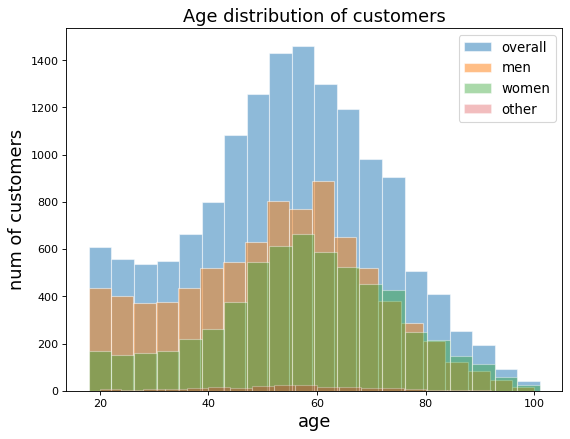

In [331]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.hist(profile['age'], bins=20,alpha=0.5, ec='w', label='overall')
plt.hist(profile[profile['gender']=='M']['age'], bins=20,alpha=0.5, ec='w', label='men')
plt.hist(profile[profile['gender']=='F']['age'], bins=20,alpha=0.4, ec='w', label='women')
plt.hist(profile[profile['gender']=='O']['age'], bins=20,alpha=0.3, ec='w', label='other')
plt.xlabel('age', fontsize=16)
plt.ylabel('num of customers', fontsize=16)
plt.title('Age distribution of customers', fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.show()

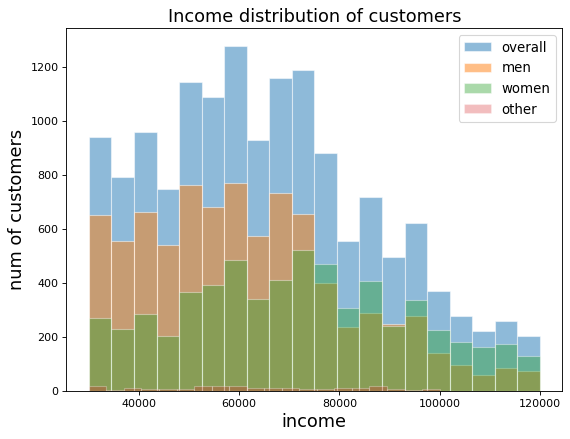

In [332]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.hist(profile['income'], bins=20,alpha=0.5, ec='w', label='overall')
plt.hist(profile[profile['gender']=='M']['income'], bins=20,alpha=0.5, ec='w', label='men')
plt.hist(profile[profile['gender']=='F']['income'], bins=20,alpha=0.4, ec='w', label='women')
plt.hist(profile[profile['gender']=='O']['income'], bins=20,alpha=0.3, ec='w', label='other')
plt.xlabel('income', fontsize=16)
plt.ylabel('num of customers', fontsize=16)
plt.title('Income distribution of customers', fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.show()

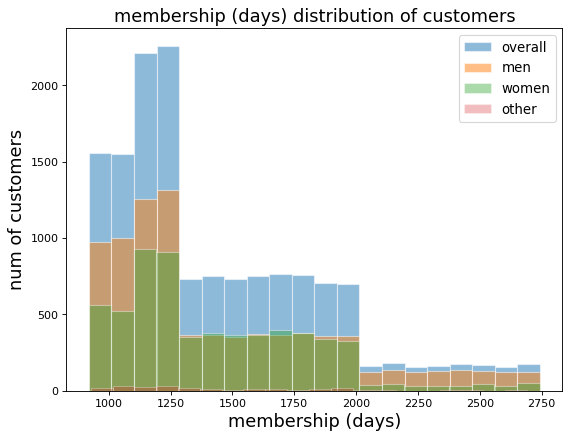

In [388]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.hist(profile['membership_days'], bins=20,alpha=0.5, ec='w', label='overall')
plt.hist(profile[profile['gender']=='M']['membership_days'], bins=20,alpha=0.5, ec='w', label='men')
plt.hist(profile[profile['gender']=='F']['membership_days'], bins=20,alpha=0.4, ec='w', label='women')
plt.hist(profile[profile['gender']=='O']['membership_days'], bins=20,alpha=0.3, ec='w', label='other')
plt.xlabel('membership (days)', fontsize=16)
plt.ylabel('num of customers', fontsize=16)
plt.title('membership (days) distribution of customers', fontsize=16)
plt.legend(loc='best',fontsize=12)
plt.show()

### 1-3 transcript dataframe

In [333]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [334]:
transcript.shape

(306534, 4)

In [335]:
# also create customer_id column in transcript, with the same mapping used in the profile dataframe
transcript['customer_id'] = transcript['person'].map(long_id_dict)

In [336]:
transcript.head(10)

,person,event,value,time,customer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,3.0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,NaN
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,4.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,5.0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,7.0


There are some NaN values in the "customer_id" column, because we removed the customers with missing info in age, gender, and income. Let's see how many rows are there:

In [337]:
transcript.isna().sum()

person             0
event              0
value              0
time               0
customer_id    33772
dtype: int64

There are 33772 rows are related to the customers who were dropped earlier (11 percent in total transcript). To be consistent, I will drop these rows in the transcript:

In [338]:
transcript.dropna(inplace=True)

In [339]:
# some more cleaning
transcript['customer_id'] = transcript['customer_id'].astype(int)
transcript.drop(columns=['person'], inplace=True)

Now let's focus on "value" column. Right now it contains dictionary, which makes it hard to analyze. Let's first seperate the key and value:

In [340]:
# Extract each key that exist in 'value' column to a seperate column.
# getting the different keys  that exists in the 'value' column
keys = []
for index, row in transcript.iterrows():
    for k in row['value']:
        keys.append(k)
keys = list(set(keys))
keys

['amount', 'offer_id', 'reward', 'offer id']

It's clear that there are 3 types of keys: "offer_id" (or "offer id"), "amount" and "reward". So let's create 3 corresponding columns:

In [341]:
# create columns and specify the datatype for each column
transcript['offer_id'] = '' # datatype: string
transcript['amount'] = 0  # datatype: integer
transcript['reward'] = 0  # datatype: integer

# iterate over the "value" column in the transcript dataframe
# then put the value into the corresponding new column
for index, row in transcript.iterrows():
    for k in row['value']:
        if k == 'amount':
            transcript.at[index, 'amount'] = row['value'][k]
        if k == 'reward':
            transcript.at[index, 'reward'] = row['value'][k]
        else:
            transcript.at[index, 'offer_id'] = row['value'][k]
            
# remove the "value" column since we have extracted all the needed info:
transcript.drop(columns=['value'], inplace=True)

Calculte the "successful" rate, which is both "view rate" (the ratio of viewing an offer over receiving it) and "complete rate" (the ratio of completing an offer over viewing it).
#### Please note:
Based on the given example, "Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer." In this case, this customer "was not influenced by the offer because the customer never viewed the offer". This is not a case that I would count into "successful" rate. 

In [342]:
bogo_list = list(portfolio[portfolio['offer_type']=='bogo']['id'])
discount_list = list(portfolio[portfolio['offer_type']=='discount']['id'])
info_list = list(portfolio[portfolio['offer_type']=='informational']['id'])

In [343]:
# delete later
trans_bogo = transcript[transcript['offer_id'].isin(bogo_list)]
trans_discount = transcript[transcript['offer_id'].isin(discount_list)]
trans_info = transcript[transcript['offer_id'].isin(info_list)]

In [344]:
# delete later
trans_bogo.shape, trans_discount.shape, trans_info.shape, 

((63834, 6), (62311, 6), (22660, 6))

Note that a customer may receive the same offer multiple times. 

In the following, I will do some processing and analysis to each of the three types of offers:
#### (1) BOGO offers:

In [345]:
bogo_df = transcript[transcript['offer_id'].isin(bogo_list)]
bogo_df = bogo_df[['event', 'customer_id']]
bogo_df = bogo_df.groupby('customer_id').count()
bogo_df['offer completed'] = 0
bogo_df['offer received'] = 0
bogo_df['offer viewed'] = 0
bogo_df['real completed'] = 0
bogo_df.drop(columns=['event'], inplace=True)

for i in range(len(bogo_list)):
    # create a temp dataframe for this particular offer
    temp = transcript[transcript['offer_id']==bogo_list[i]]
    temp = temp[['event', 'customer_id']]
    event_dummy = pd.get_dummies(temp['event'])
    temp = temp.join(event_dummy)
    temp = temp.groupby('customer_id').sum()
    
    # here I use a logic comparison to generate a new column "real completed":
    # (1) if "offer completed" is no more than "offer viewed", I treat all "offer completed" as real
    # (2) if "offer completed" is more than "offer viewed", I only treat "offer completed" after "viewed" as real
    temp['real completed'] = (temp['offer completed']<=temp['offer viewed'])*temp['offer completed']+(temp['offer completed']>temp['offer viewed'])*temp['offer viewed']
    
    # add the data from this BOGO offer to the bogo_df dataframe
    bogo_df = temp.reindex_like(bogo_df).fillna(0) + bogo_df.fillna(0).fillna(0)

Now let's create two new columns "view rate" (ratio of viewing an offer over receiving it) and "complete rate" (ratio of completing an offer over viewing it):

In [346]:
bogo_df['view rate'] = bogo_df['offer viewed']/bogo_df['offer received']
bogo_df['complete rate'] = bogo_df['real completed']/bogo_df['offer viewed']

In [347]:
bogo_df.head()

,offer completed,offer received,offer viewed,real completed,view rate,complete rate
customer_id,,,,,,
0,1.0,1.0,0.0,0.0,0.0,NaN
1,3.0,3.0,3.0,3.0,1.0,1.00
2,1.0,1.0,1.0,1.0,1.0,1.00
3,3.0,4.0,4.0,3.0,1.0,0.75
5,3.0,3.0,3.0,3.0,1.0,1.00


In [348]:
bogo_df[bogo_df['complete rate'].isna()].shape

(888, 6)

The "NaN" in "complete rate" appears because "offer viewed" is 0, which means there are 888 customers who received BOGO offer but never viewed them (regardless if they "accidentally" complete it or not). These customers are not influenced by the offer, so I will fill these "NaN" values with "0". 

In [349]:
bogo_df.fillna(0, inplace=True)

#### (2) Discount offers:

In [350]:
discount_df = transcript[transcript['offer_id'].isin(discount_list)]
discount_df = discount_df[['event', 'customer_id']]
discount_df = discount_df.groupby('customer_id').count()
discount_df['offer completed'] = 0
discount_df['offer received'] = 0
discount_df['offer viewed'] = 0
discount_df['real completed'] = 0
discount_df.drop(columns=['event'], inplace=True)

for i in range(len(discount_list)):
    # create a temp dataframe for this particular offer
    temp = transcript[transcript['offer_id']==discount_list[i]]
    temp = temp[['event', 'customer_id']]
    event_dummy = pd.get_dummies(temp['event'])
    temp = temp.join(event_dummy)
    temp = temp.groupby('customer_id').sum()
    
    # here I use a logic comparison to generate a new column "real completed":
    # (1) if "offer completed" is no more than "offer viewed", I treat all "offer completed" as real
    # (2) if "offer completed" is more than "offer viewed", I only treat "offer completed" after "viewed" as real
    temp['real completed'] = (temp['offer completed']<=temp['offer viewed'])*temp['offer completed']+(temp['offer completed']>temp['offer viewed'])*temp['offer viewed']
    
    # add the data from this discount offer to the discount_df dataframe
    discount_df = temp.reindex_like(discount_df).fillna(0) + discount_df.fillna(0).fillna(0)

In [351]:
discount_df['view rate'] = discount_df['offer viewed']/discount_df['offer received']
discount_df['complete rate'] = discount_df['real completed']/discount_df['offer viewed']

In [352]:
discount_df.isna().sum()

offer completed       0
offer received        0
offer viewed          0
real completed        0
view rate             0
complete rate      2051
dtype: int64

Again, the "NaN" in "complete rate" appears because "offer viewed" is 0, which means there are 2051 customers who received discount offer but never viewed them (regardless if they "accidentally" complete it or not). These customers are not influenced by the offer, so I will fill these "NaN" values with "0".

In [353]:
discount_df.fillna(0, inplace=True)

#### (3) Informational offers (which is advertisement without real offers, so there are only "offer received" and "offer viewed" info):

In [354]:
info_df = transcript[transcript['offer_id'].isin(info_list)]
info_df = info_df[['event', 'customer_id']]
info_df = info_df.groupby('customer_id').count()
info_df['offer received'] = 0
info_df['offer viewed'] = 0
info_df.drop(columns=['event'], inplace=True)

for i in range(len(info_list)):
    # create a temp dataframe for this particular offer
    temp = transcript[transcript['offer_id']==info_list[i]]
    temp = temp[['event', 'customer_id']]
    event_dummy = pd.get_dummies(temp['event'])
    temp = temp.join(event_dummy)
    temp = temp.groupby('customer_id').sum()
        
    # add the data from this info offer to the info_df dataframe
    info_df = temp.reindex_like(info_df).fillna(0) + info_df.fillna(0).fillna(0)

In [355]:
info_df['view rate'] = info_df['offer viewed']/info_df['offer received']

## 2. Data Visualization and Question 1

Let's take a look at the histogram of view rate and complete rate for these three types of offers (for informational offers, there's only view rate, as they do not need to be completed):

In [356]:
def plot_offer_hist_perc(df, column, title_name):
    '''
    INPUT:
    df - (pandas dataframe) dataframe to use for the plot
    column - (str) name of the column in df for the histogram
    title_name - (str) Offer type name to be inserted in the title of the plot
    
    OUTPUT:
    None
    
    Description:
    This is a function to plot histogram of a certain column ("view rate" or "complete rate")
    in a certain dataframe (individual dataframe was created for each offer type)
    
    '''
    plt.hist(df[column], weights=np.ones(len(df[column]))/len(df[column]), bins=12,alpha=0.5, ec='w')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title('{} offers {} distribution'.format(title_name, column))
    plt.xlabel('{}'.format(column))
    plt.axis([-0.1, 1.1, 0, 0.75])

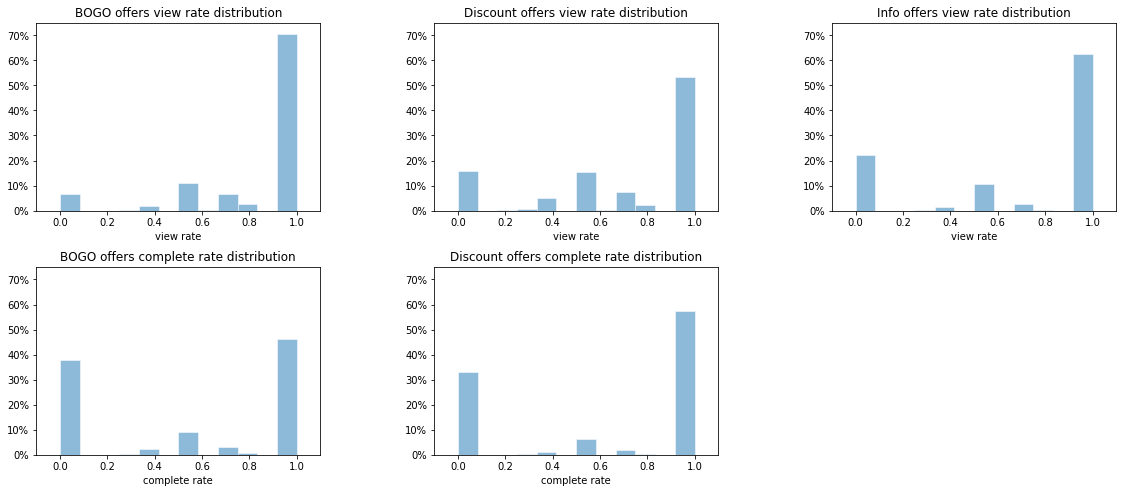

In [357]:
plt.subplots_adjust(left=0.5, bottom=0.5, right=3, top=2, wspace=0.4, hspace=0.3)
plt.subplot(231)
plot_offer_hist_perc(bogo_df, 'view rate', 'BOGO')
plt.subplot(232)
plot_offer_hist_perc(discount_df, 'view rate', 'Discount')
plt.subplot(233)
plot_offer_hist_perc(info_df, 'view rate', 'Info')
plt.subplot(234)
plot_offer_hist_perc(bogo_df, 'complete rate', 'BOGO')
plt.subplot(235)
plot_offer_hist_perc(discount_df, 'complete rate', 'Discount')

From the above histogram, we learned:  
(1) BOGO offers attract the most attention in term of view rate. 70.5% customers viewed all BOGO offers they received. Only 6.8% customers completed skipped them.   
(2) 53.2% and 63.7% customers viewed all discount and informational offers they received, respectively. 15.7% and 22.3% customers completed skipped them, which means we need to do a better job to attract customers' attention on discount and informational offers.  
(3) Although BOGO offers have a higher view rate, their complete rate is lower than discount offers. Only 46.3% customers completed all the BOGO offers they received, while 57.5% customers completed all the discount offers they received. There are 37.8% and 33.0% customers did not complete even one BOGO and discount offers (exclude those offers completed unintentionally).   
(4) So in term of "view rate", BOGO offers are the most popular; in term of "complete rate", however, discount offers are more popular than BOGO offers.  
Detailed numbers are provided in the following cells. 

In [358]:
bogo_df['view rate'].value_counts()/bogo_df['view rate'].count()

1.000000    0.705244
0.500000    0.109158
0.666667    0.068185
0.000000    0.067880
0.750000    0.023467
0.333333    0.017352
0.800000    0.003975
0.250000    0.002064
0.600000    0.001682
0.400000    0.000612
0.833333    0.000229
0.200000    0.000153
Name: view rate, dtype: float64

In [359]:
bogo_df['complete rate'].value_counts()/bogo_df['complete rate'].count()

1.000000    0.463232
0.000000    0.378153
0.500000    0.092188
0.666667    0.029888
0.333333    0.022856
0.750000    0.006803
0.250000    0.004281
0.800000    0.000917
0.600000    0.000764
0.200000    0.000459
0.400000    0.000382
0.833333    0.000076
Name: complete rate, dtype: float64

In [360]:
discount_df['view rate'].value_counts()/discount_df['view rate'].count()

1.000000    0.532127
0.000000    0.157261
0.500000    0.155038
0.666667    0.072458
0.333333    0.046005
0.750000    0.019859
0.250000    0.006901
0.600000    0.003297
0.800000    0.003297
0.400000    0.002607
0.200000    0.000843
0.833333    0.000230
0.166667    0.000077
Name: view rate, dtype: float64

In [361]:
discount_df['complete rate'].value_counts()/discount_df['complete rate'].count()

1.000000    0.574298
0.000000    0.329857
0.500000    0.061110
0.666667    0.018095
0.333333    0.009431
0.750000    0.004370
0.250000    0.001687
0.800000    0.000460
0.600000    0.000307
0.400000    0.000230
0.200000    0.000077
0.833333    0.000077
Name: complete rate, dtype: float64

In [362]:
info_df['view rate'].value_counts()/info_df['view rate'].count()

1.000000    0.626630
0.000000    0.222717
0.500000    0.107500
0.666667    0.024783
0.333333    0.014783
0.750000    0.002609
0.250000    0.000870
0.800000    0.000109
Name: view rate, dtype: float64

## 3. Save the clean dataset into an sqlite database.

In [253]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///Merged_bogo_df.db')
merged_bogo.to_sql('Merged_bogo', engine, if_exists = 'replace', index=False)
engine.dispose()

In [250]:
engine = create_engine('sqlite:///Merged_discount_df.db')
merged_discount.to_sql('Merged_discount', engine, if_exists = 'replace', index=False)
engine.dispose()